In [98]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import emoji
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from pandarallel import pandarallel
from src.visualization.emoji_plotting import plot_emoji_barplot

pandarallel.initialize(nb_workers=8)
from src.data.utils import save_to_csv, parallelize_dataframe

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


### Calculate variances and a baseline

In [2]:
path = "/scratch/czestoch/bert_variances.csv.gz"
variances = pd.read_csv(path)

In [ ]:
# path = "/scratch/czestoch/bert_emojis.csv.gz"
path = "/scratch/czestoch/bert_emojis_with_unknown_emojis.csv.gz"
bert = pd.read_csv(path)

In [193]:
len(bert)

314212

In [195]:
save_to_csv(bert, "/scratch/czestoch/bert_emojis_with_unknown_emojis.csv.gz")

In [178]:
bert.groupby("emoji").tweet.count().sort_values()

emoji
:eye_in_speech_bubble_selector:      16
:pause_button_selector:              28
:lab_coat:                           30
:badger:                             30
:foot:                               30
                                   ... 
:sparkles:                         2983
:smiling_face_with_heart-eyes:     3398
:red_heart_selector:               3790
:face_with_tears_of_joy:           5627
:fire:                             6646
Name: tweet, Length: 1193, dtype: int64

In [162]:
# For emojis model was trained with
# equalized = bert.groupby("emoji").sample(n=30, random_state=42)

In [179]:
# For all emojis version
# eye in speech bubble has only 16 occurrences and all come from the same tweet, it's variance is 0 then
equalized = bert[~bert.emoji.isin([":eye_in_speech_bubble_selector:", ":pause_button_selector:"])]\
                    .groupby("emoji").sample(n=30, random_state=42)
# pause button selector has only 28 occurrences so we add it here later
equalized = pd.concat((bert[bert.emoji.isin([":pause_button_selector:"])], equalized))
equalized = pd.concat((bert[bert.emoji.isin([":eye_in_speech_bubble_selector:"])], equalized))

In [180]:
len(equalized)

35774

In [181]:
def calculate_variance(group):
    ls = group.embedding.tolist()
    matrix = np.array([eval(l) for l in ls])
    return np.sum(matrix.var(1))

In [182]:
variances = equalized.groupby("emoji").parallel_apply(calculate_variance)

In [183]:
variances.describe()

count    1193.000000
mean        4.786517
std         0.986265
min         2.773700
25%         3.937124
50%         4.589535
75%         5.580967
max         9.142858
dtype: float64

In [184]:
baselines = []
for i in tqdm(range(1000)):
    ls = bert.loc[equalized.tweet.drop_duplicates().sample(n=30).index].embedding.tolist()
#     ls = equalized.sample(n=30, random_state=42+i).embedding.tolist()
    matrix = np.array([eval(l) for l in ls])
    variance = np.sum(matrix.var(1))
    baselines.append(variance)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [185]:
alpha = 5    
baseline = np.nanmedian(np.array(baselines))
baselines_CIs = [np.nanpercentile(baselines, alpha / 2),\
                         np.nanpercentile(baselines, 100 - (alpha / 2))] 

In [186]:
baseline

5.11435903143151

In [187]:
variances = variances.reset_index()
variances = variances.rename({0: "variance"}, axis=1)
variances.emoji = variances.emoji.parallel_apply(emoji.emojize)

In [188]:
variances.head()

,emoji,variance
0,🥇,5.501229
1,🥈,5.426275
2,🥉,5.734660
3,🆎,3.958940
4,🏧,6.786680


In [ ]:
# pd.set_option('mode.chained_assignment', None)

# sns.set(rc={'figure.figsize':(15, 7)}, font_scale=1.3)
# sns.set_style("white", {'axes.grid' : False})

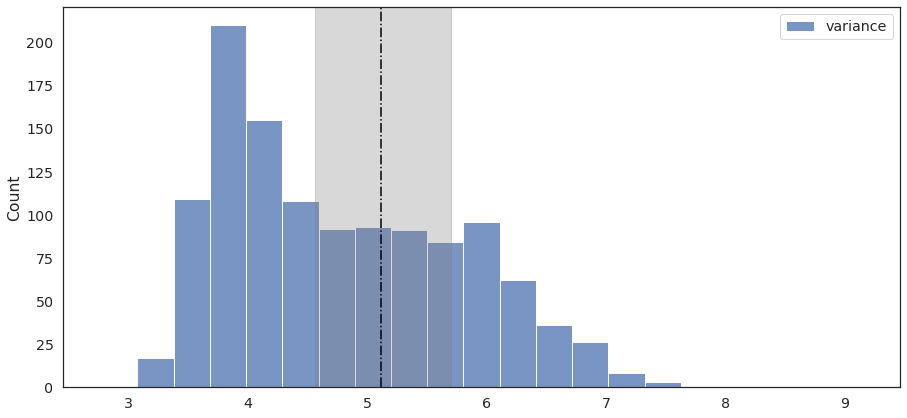

In [189]:
g = sns.histplot(variances)
g.axvline(baseline, linestyle="-.", color='black')
g.axvspan(baselines_CIs[0], baselines_CIs[1], alpha=0.3, color='gray')

In [190]:
variances.describe()

,variance
count,1193.000000
mean,4.786517
std,0.986265
min,2.773700
25%,3.937124
50%,4.589535
75%,5.580967
max,9.142858


In [133]:
variances[variances.emoji == '💁']

,emoji,variance
820,💁,3.965764


In [134]:
variances[variances.emoji == '🛂']

,emoji,variance
775,🛂,3.830688


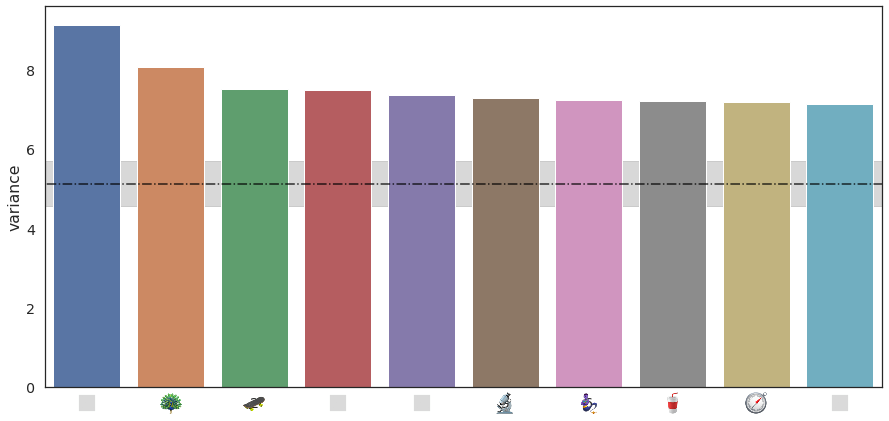

In [191]:
top_ten = variances.nlargest(10, columns='variance').reset_index()

fig, ax = plt.subplots()
ax.plot(range(-2, 12), 14*[baseline], '-.', alpha=0.8, color='black')
ax.fill_between(range(-2, 12), baselines_CIs[0],
                 baselines_CIs[1], alpha = 0.3, color='gray')
plot_emoji_barplot(top_ten, ax, col='variance', cluster=True)

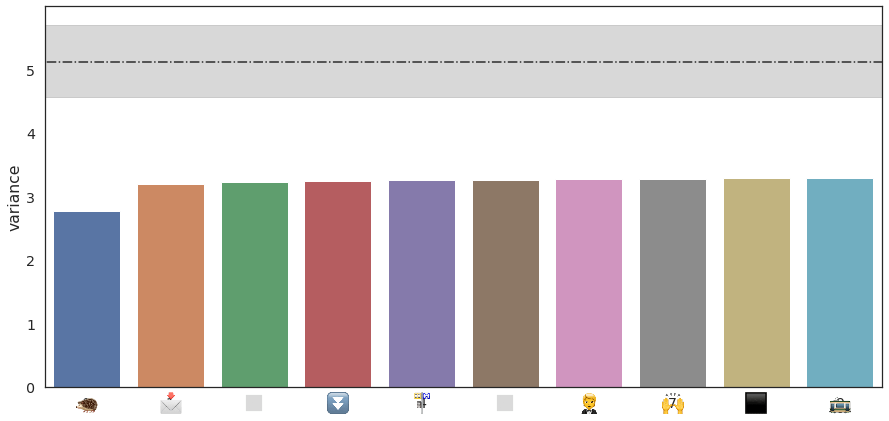

In [192]:
low_ten = variances.nsmallest(10, columns='variance').reset_index()

fig, ax = plt.subplots()
ax.plot(range(-2, 12), 14*[baseline], '-.', alpha=0.8, color='black')
ax.fill_between(range(-2, 12), baselines_CIs[0],
                 baselines_CIs[1], alpha = 0.3, color='gray')
plot_emoji_barplot(low_ten, ax, col='variance', cluster=True)

In [138]:
top_ten

,index,emoji,variance
0,216,♟️,9.142858
1,780,🦚,8.073407
2,958,🛹,7.507712
3,659,🕰️,7.481257
4,594,🏷️,7.373338
5,674,🔬,7.294431
6,474,🧞,7.242478
7,297,🥤,7.222137
8,257,🧭,7.199985
9,316,🖥️,7.132037


In [141]:
low_ten

,index,emoji,variance
0,528,🦔,2.773700
1,362,📩,3.196291
2,1144,◻️,3.225668
3,420,⏬,3.249471
4,181,🚏,3.256187
5,895,⛑️,3.264437
6,648,🤵,3.267084
7,879,🙌,3.276693
8,141,⬛,3.283933
9,1079,🚋,3.284970


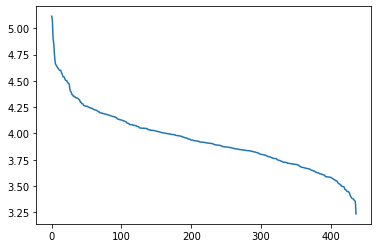

In [82]:
# plt.plot(variances.sort_values("variance", ascending=False).variance.values)